# Gender Classification
<p>Train and Evaluate multiple CNN architecture for Gender Classification</p>
<p>Dataset is subset of CelebA with 5K images that can be downloaded from <a href="https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB">Google Drive</a>. The notebook is configured to download the dataset automatically without any manual copy-paste required</p>

# Import Libraries
<p>
    You might need to install the libraries separately with below commands if import library is not successful:
    <li>pip install pandas</li>
    <li>pip install scikit-learn</li>
    <li>pip install torch</li>
    <li>pip install torchvision</li>
    <li>pip install Pillow</li>
    <li>pip install matplotlib</li>
    <li>pip install imagehash</li>
    <li>pip install seaborn</li>
</p>

In [1]:
!pip install imagehash

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import imagehash
import time
from torch.autograd import Variable

# Data Preparation

In [3]:
# setup default folders for storing dataset, model state and reports
# modify this line according to your Notebook Environment
data_path='./Dataset/Dataset5K' # dataset
model_path='./Models' # model state
eval_path='./Evaluation/Training' # training evaluation report
os.makedirs(model_path, exist_ok=True)
os.makedirs(eval_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## Download Dataset
This cell is optional and can be skipped if the dataset is already available in data_path
You might need to install gdown library with command: <b>pip install gdown</b> to run this cell below

In [4]:
import gdown
import zipfile
# File URL
file_url = "https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB"

# Output file name
output = "./Dataset/Dataset5K.zip"

if not os.path.exists(output):
    # Download the file
    gdown.download(file_url, output, quiet=False)
    print("Download completed!")

if os.path.exists(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(data_path)

Downloading...
From (original): https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB
From (redirected): https://drive.google.com/uc?id=15eVWQjexrUvX0EniEJcENZ5gG8kDByhB&confirm=t&uuid=d4597e56-b60e-491a-a47e-223bf3038e7d
To: Z:\BEKA\2025\AI\Bootcamp\Source\Fundamental CV\Project 1 Gender Classification\Dataset\Dataset5K.zip
100%|███████████████████████████████████████████████████████████████████████████████| 287M/287M [00:26<00:00, 10.9MB/s]


Download completed!


## EDA Dataset

In [5]:
os.listdir(data_path)

['class_identity.txt',
 'gender_classification.csv',
 'gender_classification.xlsx',
 'Images',
 'list_attribute.txt',
 'model_saved']

In [6]:
images_path = os.path.join(data_path, 'Images')
images_list = os.listdir(images_path)

In [7]:
def calculate_phash(image_path):
     """Calculates the perceptual hash of an image."""
     try:
         img = Image.open(image_path)
         hash_value = imagehash.phash(img)
         return hash_value
     except Exception as e:
         print(f"Error processing {image_path}: {e}")
         return None

def find_duplicate_images(image_folder, images_list):
     """Finds duplicate images based on their perceptual hashes."""
     hashes = {}
     duplicates = []

     for image_path in images_list:
         hash_value = calculate_phash(os.path.join(image_folder, image_path))
         if hash_value is None:
             continue

         if hash_value in hashes:
             duplicates.append((hashes[hash_value], image_path))
         else:
             hashes[hash_value] = image_path
     return duplicates

In [8]:
# load the data
data = pd.read_csv(data_path + '/list_attribute.txt', sep='\\s+', skiprows=1)
# filter the data with available images only (5000 images)
filter_index = data.index.intersection(images_list)
data = data.loc[filter_index]['Male'].reset_index().rename(columns={'index':'Filename'})
data['Male'] = np.where(data['Male'] == 1, 1, 0)
data.head()

,Filename,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0


### Check and remove file duplication

Duplicated images: 2


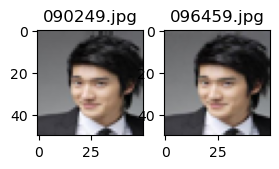

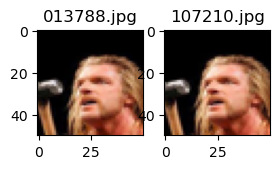

In [9]:
duplicates = find_duplicate_images(data_path + '/Images', data['Filename'])

print(f'Duplicated images: {len(duplicates)}')
# show duplicated images, take max 3 images as sample
for ix, dup_images in enumerate(duplicates):
    if ix == 3:
        break
    count = len(dup_images)
    fig, axs = plt.subplots(1, count, figsize=(1.5 * len(duplicates), 1.5))  # smaller figure

    for iy, dup_image in enumerate(dup_images):
        img = Image.open(os.path.join(images_path, dup_image)).resize((50, 50))  # very small thumbnail
        axs[iy].imshow(img)
        axs[iy].set_title(f"{dup_image}")


In [10]:
# remove duplicate images and maintain only 1 data
rem_images = []
for dup_images in duplicates:
    rem_images += dup_images[1:]
data = data[~data['Filename'].isin(rem_images)]

# validate duplication again to ensure data is clean
duplicates = find_duplicate_images(data_path + '/Images', data['Filename'])
print(f'Duplicates: {len(duplicates)}, Dataset shape: {data.shape}')

Duplicates: 0, Dataset shape: (4998, 2)


### Explore image resolution variation

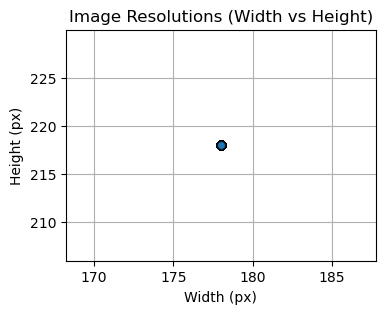

In [11]:
# Lists to hold widths and heights
widths = []
heights = []

# Iterate through image files
for filename in images_list:
    try:
        img_path = os.path.join(images_path, filename)
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except Exception as e:
        print(f"Error with {filename}: {e}")

# Plot width vs height
plt.figure(figsize=(4, 3))
plt.scatter(widths, heights, alpha=0.6, edgecolors='k')
plt.title("Image Resolutions (Width vs Height)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.grid(True)
plt.show()

### Explore dataset label variation

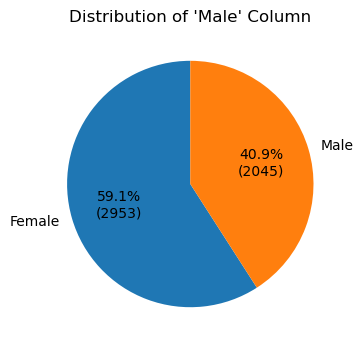

In [12]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return my_format

# Count occurrences of each unique label in 'Male' column
labels = data['Male'].map({0:'Female', 1:'Male'})
label_counts = labels.value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
label_counts.plot.pie(autopct=autopct_format(label_counts), startangle=90)
plt.title("Distribution of 'Male' Column")
plt.ylabel('')  # Hide y-label
plt.show()

In [13]:
# save clean dataset so that it can be re-used by separate evaluation scripe
data.to_csv(os.path.join(data_path, 'clean_dataset.csv'), index=False)

### Split Train and Test data

In [14]:
# split the data into train and test sets with a 70:15:15 ratio
# First split: train (70%) and temp (30%)
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)

# Second split: split temp (30%) into val (15%) and test (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

data.shape, train_data.shape, test_data.shape, val_data.shape

((4998, 2), (3498, 2), (750, 2), (750, 2))

In [15]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])

        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')

        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

### Data Augmentation and Preparation

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # Resize to match model input size
    transforms.RandomHorizontalFlip(),             # Randomly flip images horizontally
    transforms.RandomRotation(10),                 # Random rotation between -10 and 10 degrees
    transforms.ColorJitter(brightness=0.2,         # Random brightness, contrast, saturation
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                         # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same as training
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same as training
                         std=[0.229, 0.224, 0.225])
])

In [17]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=train_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

val_set = GenderDataset(val_data, os.path.join(data_path, "Images"), transform=val_transform)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=0)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

#### Show train data Augmentation result

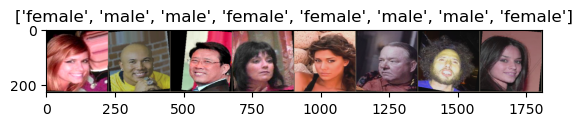

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
# limit to 8 images only
inputs = inputs[:8]
classes = classes[:8]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['female', 'male']
imshow(out, title=[class_names[x] for x in classes])

# Modeling

In [19]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, model_name, use_gpu=torch.cuda.is_available(),num_epochs=10):
    # please define the training model (VGG/GoogleNet/ResNet) here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = 0

    acc_histories = []
    loss_histories = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        acc_history = { 'train': 0, 'val': 0 }
        loss_history = { 'train': 0, 'val': 0 }
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for data in dataloders[phase]:
                 # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                 # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_history[phase] = round(epoch_acc.item(), 4)
            loss_history[phase] = round(epoch_loss.item(), 4)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = round(epoch_acc.item(), 4)
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state, os.path.join(model_path, model_name))
                best_epoch = epoch
                print(f'✅ Best model saved! (Accuracy: {best_acc})')
        acc_histories.append(acc_history)
        loss_histories.append(loss_history)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch

def store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_history, loss_histories):
    train_values = np.array([item['train'] for item in acc_histories])
    test_values = np.array([item['val'] for item in acc_histories])

    l_train_values = np.array([item['train'] for item in loss_histories])
    l_test_values = np.array([item['val'] for item in loss_histories])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()  # flatten 2x2 grid to list for easy indexing
    # Plot training and validation accuracy
    axs[0].plot(train_values, label='Training Accuracy')
    axs[0].plot(test_values, label='Validation Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim(0.5, 1.00)
    axs[0].legend()

    # Plot training and validation loss
    axs[1].plot(l_train_values, label='Training Accuracy')
    axs[1].plot(l_test_values, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.savefig(os.path.join(eval_path, model_name + '_train_loss.png'), dpi=300)
    plt.show()

    df = pd.DataFrame({'train': train_values, 'test': test_values})
    df.to_csv(os.path.join(eval_path, model_name + '_train_acc.csv'))

    device_name = 'cpu'
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
    df_sum = pd.DataFrame({'model': [model_name],
                           'device': [device_name],
                           'time_elapsed' : [time_elapsed],
                           'best_epoch': [best_epoch],
                           'best_acc': [best_acc]})
    df_sum.to_csv(os.path.join(eval_path, model_name + '_train_sum.csv'))
    print(df_sum)

In [20]:
dataloders = {
    "train":train_loader, "val":val_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "val":len(val_set), "test":len(test_set)
}

# Architectures and Model Training

In [21]:
use_gpu = torch.cuda.is_available()
num_epoch = 30

In [22]:
# GoogleNet default weights
def googlenet(use_gpu):
    model = models.googlenet(aux_logits=False, init_weights=False)
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'googlenet_5k_best.pth'
    return model, model_name

# GoogleNet pre-trained ImageNet
def googlenet_pt(use_gpu):
    weights = models.GoogLeNet_Weights.DEFAULT
    model = models.googlenet(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'googlenet_pt_5k_best.pth'
    return model, model_name

# ResNet18 default weights
def resnet18(use_gpu):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'resnet18_5k_best.pth'
    return model, model_name

# ResNet18 pre-trained ImageNet
def resnet18_pt(use_gpu):
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'resnet18_pt_5k_best.pth'
    return model, model_name

# Vgg16 default weights
def vgg16(use_gpu):
    model = models.vgg16()
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'vgg16_5k_best.pth'
    return model, model_name

# Vgg16 pre-trained ImageNet
def vgg16_pt(use_gpu):
    weights = models.VGG16_Weights.DEFAULT
    model = models.vgg16(weights=weights)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    if use_gpu:
        model.to('cuda')
    model_name = 'vgg16_pt_5k_best.pth'
    return model, model_name

## GoogleNet Default Weights (without Freeze Layer)

In [23]:
model, model_name = googlenet(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [24]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, num_epoch)

Epoch 0/29
----------
train Loss: 0.0181 Acc: 0.6933
val Loss: 0.0145 Acc: 0.7893
✅ Best model saved! (Accuracy: 0.7893)

Epoch 1/29
----------
train Loss: 0.0144 Acc: 0.7882
val Loss: 0.0125 Acc: 0.8213
✅ Best model saved! (Accuracy: 0.8213)

Epoch 2/29
----------
train Loss: 0.0122 Acc: 0.8230
val Loss: 0.0128 Acc: 0.8307
✅ Best model saved! (Accuracy: 0.8307)

Epoch 3/29
----------
train Loss: 0.0096 Acc: 0.8674
val Loss: 0.0078 Acc: 0.8973
✅ Best model saved! (Accuracy: 0.8973)

Epoch 4/29
----------
train Loss: 0.0081 Acc: 0.8885
val Loss: 0.0073 Acc: 0.9027
✅ Best model saved! (Accuracy: 0.9027)

Epoch 5/29
----------
train Loss: 0.0063 Acc: 0.9165
val Loss: 0.0089 Acc: 0.8933

Epoch 6/29
----------
train Loss: 0.0061 Acc: 0.9205
val Loss: 0.0074 Acc: 0.9040
✅ Best model saved! (Accuracy: 0.904)

Epoch 7/29
----------
train Loss: 0.0054 Acc: 0.9260
val Loss: 0.0053 Acc: 0.9320
✅ Best model saved! (Accuracy: 0.932)

Epoch 8/29
----------
train Loss: 0.0053 Acc: 0.9345
val Loss: 0.

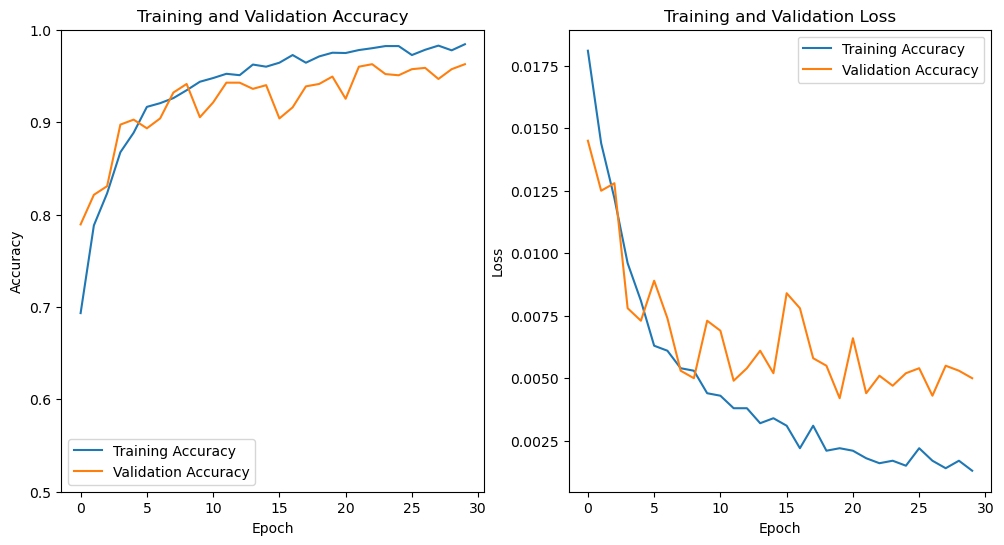

                   model                              device  time_elapsed  \
0  googlenet_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU    556.602479   

   best_epoch  best_acc  
0          22    0.9627  


In [25]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## GoogleNet Pre-Trained with ImageNet Dataset

In [26]:
model, model_name = googlenet_pt(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [27]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, num_epoch)

Epoch 0/29
----------
train Loss: 0.0076 Acc: 0.9068
val Loss: 0.0046 Acc: 0.9427
✅ Best model saved! (Accuracy: 0.9427)

Epoch 1/29
----------
train Loss: 0.0038 Acc: 0.9545
val Loss: 0.0031 Acc: 0.9613
✅ Best model saved! (Accuracy: 0.9613)

Epoch 2/29
----------
train Loss: 0.0022 Acc: 0.9774
val Loss: 0.0033 Acc: 0.9693
✅ Best model saved! (Accuracy: 0.9693)

Epoch 3/29
----------
train Loss: 0.0019 Acc: 0.9794
val Loss: 0.0026 Acc: 0.9733
✅ Best model saved! (Accuracy: 0.9733)

Epoch 4/29
----------
train Loss: 0.0014 Acc: 0.9866
val Loss: 0.0027 Acc: 0.9720

Epoch 5/29
----------
train Loss: 0.0011 Acc: 0.9886
val Loss: 0.0022 Acc: 0.9800
✅ Best model saved! (Accuracy: 0.98)

Epoch 6/29
----------
train Loss: 0.0008 Acc: 0.9929
val Loss: 0.0026 Acc: 0.9747

Epoch 7/29
----------
train Loss: 0.0006 Acc: 0.9934
val Loss: 0.0027 Acc: 0.9747

Epoch 8/29
----------
train Loss: 0.0010 Acc: 0.9923
val Loss: 0.0028 Acc: 0.9707

Epoch 9/29
----------
train Loss: 0.0009 Acc: 0.9894
val Los

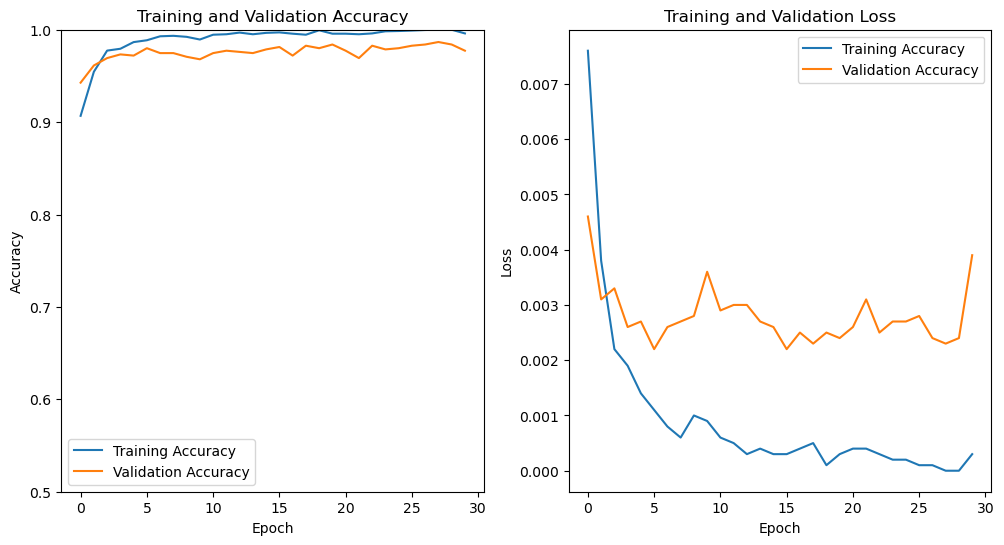

                      model                              device  time_elapsed  \
0  googlenet_pt_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU    559.801942   

   best_epoch  best_acc  
0          27    0.9867  


In [28]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## ResNet18 Default Weights (without Freeze Layer)

In [29]:
model, model_name = resnet18(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [30]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, num_epoch)

Epoch 0/29
----------
train Loss: 0.0183 Acc: 0.6910
val Loss: 0.0139 Acc: 0.7947
✅ Best model saved! (Accuracy: 0.7947)

Epoch 1/29
----------
train Loss: 0.0125 Acc: 0.8222
val Loss: 0.0088 Acc: 0.8853
✅ Best model saved! (Accuracy: 0.8853)

Epoch 2/29
----------
train Loss: 0.0089 Acc: 0.8768
val Loss: 0.0114 Acc: 0.8467

Epoch 3/29
----------
train Loss: 0.0071 Acc: 0.9031
val Loss: 0.0090 Acc: 0.8960
✅ Best model saved! (Accuracy: 0.896)

Epoch 4/29
----------
train Loss: 0.0054 Acc: 0.9325
val Loss: 0.0068 Acc: 0.9240
✅ Best model saved! (Accuracy: 0.924)

Epoch 5/29
----------
train Loss: 0.0052 Acc: 0.9291
val Loss: 0.0052 Acc: 0.9373
✅ Best model saved! (Accuracy: 0.9373)

Epoch 6/29
----------
train Loss: 0.0049 Acc: 0.9394
val Loss: 0.0045 Acc: 0.9480
✅ Best model saved! (Accuracy: 0.948)

Epoch 7/29
----------
train Loss: 0.0043 Acc: 0.9488
val Loss: 0.0064 Acc: 0.9320

Epoch 8/29
----------
train Loss: 0.0039 Acc: 0.9545
val Loss: 0.0045 Acc: 0.9440

Epoch 9/29
----------


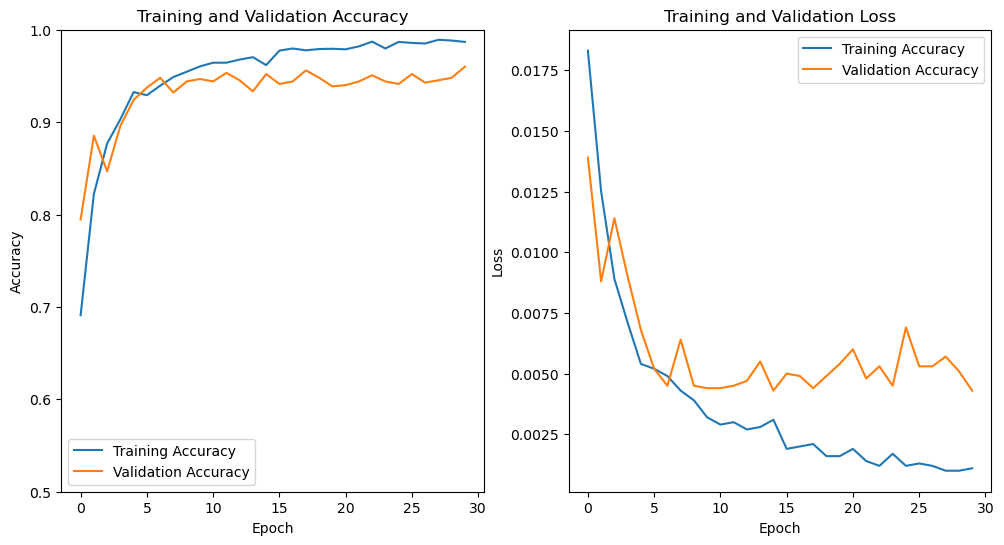

                  model                              device  time_elapsed  \
0  resnet18_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU    510.878319   

   best_epoch  best_acc  
0          29      0.96  


In [31]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## ResNet18 Pre-Trained with ImageNet Dataset

In [32]:
model, model_name = resnet18_pt(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [33]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, num_epoch)

Epoch 0/29
----------
train Loss: 0.0064 Acc: 0.9125
val Loss: 0.0033 Acc: 0.9680
✅ Best model saved! (Accuracy: 0.968)

Epoch 1/29
----------
train Loss: 0.0031 Acc: 0.9603
val Loss: 0.0025 Acc: 0.9693
✅ Best model saved! (Accuracy: 0.9693)

Epoch 2/29
----------
train Loss: 0.0022 Acc: 0.9728
val Loss: 0.0028 Acc: 0.9707
✅ Best model saved! (Accuracy: 0.9707)

Epoch 3/29
----------
train Loss: 0.0017 Acc: 0.9783
val Loss: 0.0020 Acc: 0.9813
✅ Best model saved! (Accuracy: 0.9813)

Epoch 4/29
----------
train Loss: 0.0018 Acc: 0.9774
val Loss: 0.0038 Acc: 0.9573

Epoch 5/29
----------
train Loss: 0.0014 Acc: 0.9868
val Loss: 0.0023 Acc: 0.9760

Epoch 6/29
----------
train Loss: 0.0010 Acc: 0.9874
val Loss: 0.0023 Acc: 0.9733

Epoch 7/29
----------
train Loss: 0.0006 Acc: 0.9937
val Loss: 0.0021 Acc: 0.9733

Epoch 8/29
----------
train Loss: 0.0004 Acc: 0.9957
val Loss: 0.0022 Acc: 0.9773

Epoch 9/29
----------
train Loss: 0.0005 Acc: 0.9943
val Loss: 0.0021 Acc: 0.9760

Epoch 10/29
---

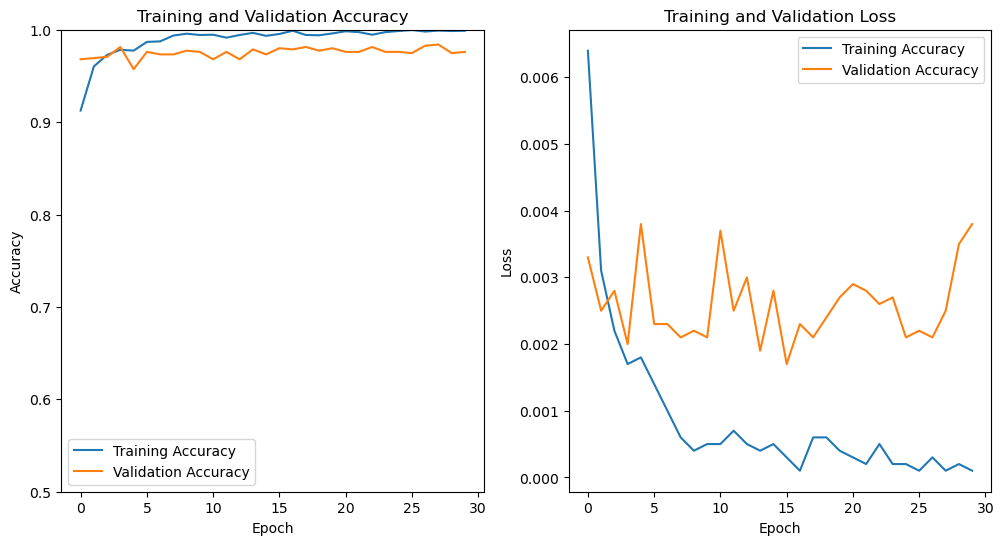

                     model                              device  time_elapsed  \
0  resnet18_pt_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU    507.968864   

   best_epoch  best_acc  
0          27     0.984  


In [34]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## Vgg16 Default Weights (without Freeze Layer)

In [35]:
model, model_name = vgg16(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [36]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, num_epoch)

Epoch 0/29
----------
train Loss: 0.0203 Acc: 0.6266
val Loss: 0.0191 Acc: 0.6987
✅ Best model saved! (Accuracy: 0.6987)

Epoch 1/29
----------
train Loss: 0.0166 Acc: 0.7467
val Loss: 0.0150 Acc: 0.7800
✅ Best model saved! (Accuracy: 0.78)

Epoch 2/29
----------
train Loss: 0.0129 Acc: 0.8148
val Loss: 0.0072 Acc: 0.9080
✅ Best model saved! (Accuracy: 0.908)

Epoch 3/29
----------
train Loss: 0.0088 Acc: 0.8854
val Loss: 0.0069 Acc: 0.9280
✅ Best model saved! (Accuracy: 0.928)

Epoch 4/29
----------
train Loss: 0.0067 Acc: 0.9160
val Loss: 0.0074 Acc: 0.9120

Epoch 5/29
----------
train Loss: 0.0063 Acc: 0.9257
val Loss: 0.0054 Acc: 0.9413
✅ Best model saved! (Accuracy: 0.9413)

Epoch 6/29
----------
train Loss: 0.0057 Acc: 0.9265
val Loss: 0.0088 Acc: 0.9107

Epoch 7/29
----------
train Loss: 0.0052 Acc: 0.9351
val Loss: 0.0050 Acc: 0.9387

Epoch 8/29
----------
train Loss: 0.0046 Acc: 0.9420
val Loss: 0.0073 Acc: 0.9213

Epoch 9/29
----------
train Loss: 0.0046 Acc: 0.9374
val Loss:

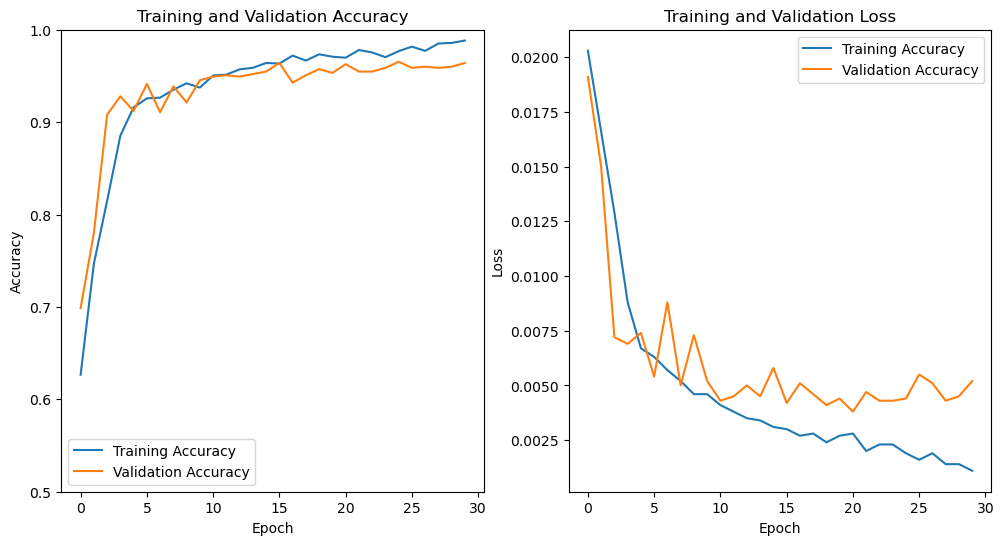

               model                              device  time_elapsed  \
0  vgg16_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   3407.822556   

   best_epoch  best_acc  
0          24    0.9653  


In [37]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)

## ## Vgg16 Pre-Trained with ImageNet dataset

In [38]:
model, model_name = vgg16_pt(use_gpu)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [39]:
model, acc_histories, loss_histories, best_acc, time_elapsed, best_epoch = train_model(
    model, dataloders, dataset_sizes, criterion, optimizer, model_name, use_gpu, num_epoch)

Epoch 0/29
----------
train Loss: 0.0074 Acc: 0.8962
val Loss: 0.0039 Acc: 0.9587
✅ Best model saved! (Accuracy: 0.9587)

Epoch 1/29
----------
train Loss: 0.0044 Acc: 0.9488
val Loss: 0.0029 Acc: 0.9640
✅ Best model saved! (Accuracy: 0.964)

Epoch 2/29
----------
train Loss: 0.0027 Acc: 0.9706
val Loss: 0.0030 Acc: 0.9680
✅ Best model saved! (Accuracy: 0.968)

Epoch 3/29
----------
train Loss: 0.0023 Acc: 0.9734
val Loss: 0.0027 Acc: 0.9640

Epoch 4/29
----------
train Loss: 0.0020 Acc: 0.9777
val Loss: 0.0025 Acc: 0.9720
✅ Best model saved! (Accuracy: 0.972)

Epoch 5/29
----------
train Loss: 0.0018 Acc: 0.9771
val Loss: 0.0025 Acc: 0.9747
✅ Best model saved! (Accuracy: 0.9747)

Epoch 6/29
----------
train Loss: 0.0017 Acc: 0.9820
val Loss: 0.0033 Acc: 0.9680

Epoch 7/29
----------
train Loss: 0.0022 Acc: 0.9774
val Loss: 0.0021 Acc: 0.9787
✅ Best model saved! (Accuracy: 0.9787)

Epoch 8/29
----------
train Loss: 0.0011 Acc: 0.9877
val Loss: 0.0028 Acc: 0.9827
✅ Best model saved! (Ac

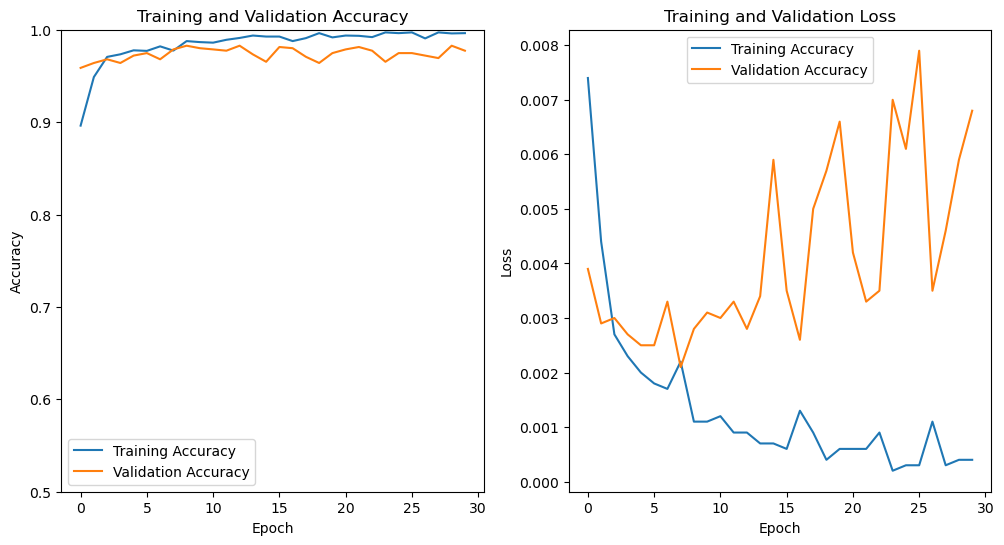

                  model                              device  time_elapsed  \
0  vgg16_pt_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU    3388.83443   

   best_epoch  best_acc  
0           8    0.9827  


In [40]:
store_train_logs(model_name, time_elapsed, best_epoch, best_acc, acc_histories, loss_histories)